title: "Capstone Project: Tea Recommender System"
author: "Amjad Alqahtani"
date: "16/11/2021"

Recommender Systems are everywhere around us, from ads, to music apps, to search engines, they influence our decisions in implicit yet impactful ways. Building recommender systems can vary in difficulty based on complexity, but below is a simple example of a straight forward recommendation system using unique data gathered from online sources. The goal of the Tea Recommender is to generate tea recommendations for users based on their preferred tea. Unlike online examples of recommender systems that measure similarity based on description, here we will use the ingredients to find similarity between the teas.

In [37]:
# Import the necessary libraries for basic functions, NLP, RegEx,
# calculating similarity, requests, and data visualization
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 100)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import DefaultTagger
from nltk.corpus import treebank
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
import re
import string
import random
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Nice, but not necessary, watch time when executing text processing tasks. *This is more useful for larger datasets with long computing times.
from tqdm import tqdm
tqdm.pandas()

In [7]:
# Import dataset and set 'encoding = 'unicode_escape' to avoid UnicodeDecodeError
df = pd.read_csv("C:/Users/Glow9/Documents/Misk-DSI-2021/Capstone/data-tidying/clean_megalist.csv", encoding = 'unicode_escape')

In [8]:
# Rename column make it one word to remove the dot
df = df.rename(columns = {"Health.Problem": "HealthP"}, inplace = False)

In [9]:
# View head and make sure the type is a Pandas DataFrame
df.head()

,ID,Caffeine,Flavor,Description,Name,Origin,Time,Color,Ingredients,Price,Brand,HealthP,Type,urls
0,14,no,mint and citrus,The cold solution you need Our comforting organic herbal tea features a throat calming base of p...,Organic Cold 911 Iconic Tin,Unknown,Anytime,light yellow,"Organic peppermint, Organic apple, Organic eucalyptus, Organic juniper berries, Organic orange o...",12.0,davidstea,"indigestion, constipation, IBS, motion sickness, migraines, headaches",Herbal Tea,https://davidstea.com/us_en/tea/shop-all/organic-cold-911-iconic-tin/961015US01VAR0056871.html?c...
1,16,yes,sweet and sour,What are we grateful for? Lets start with this purifying tea made with juicy pomegranates Not on...,Pomegrateful Iconic Tin,Unknown,Anytime,pink,"Apple (apple, citric acid), Pineapple (pineapple, sugar), Hibiscus blossoms, White tea, Natural ...",20.0,davidstea,"cancer prevention, kidney stones, high blood pressure",White Tea,https://davidstea.com/us_en/tea/shop-all/pomegrateful-iconic-tin/961028US01VAR0057010.html?cgid=...
2,19,yes,earthy mint and citrus,Wild mint meets notes of freshly squeezed lime in this strong yet refreshing flavoured Mojito Ma...,Mojito Matcha Iconic Tin,Unknown,day,green,"Cane sugar, Matcha green tea, Natural Mojito flavouring.",25.0,davidstea,"lack of focus, slow metabolism, inflammation, high blood pressure, high cholesterol, unclear skin",Matcha,https://davidstea.com/us_en/tea/shop-all/mojito-matcha-iconic-tin/961604US01.html?cgid=tea-colle...
3,20,yes,sweet and sour,What are we grateful for? Lets start with this purifying tea made with juicy pomegranates Not on...,Pomegrateful Limited Edition printed tin,Unknown,anytime,pink,"Apple (apple, citric acid), Pineapple (pineapple, sugar), Hibiscus blossoms, White tea, Natural ...",19.0,davidstea,"cancer prevention, kidney stones, high blood pressure",White Tea,https://davidstea.com/us_en/tea/shop-all/pomegrateful-%E2%80%93-limited-edition-printed-tin/9613...
4,21,yes,earthy and sweet,This all natural blend of vanilla matcha green tea powder and sweet coconut nectar is the easies...,Vanilla Matcha Iconic Tin,Unknown,day,green,"Coconut nectar, Matcha green tea, Natural vanilla flavouring.",25.0,davidstea,"lack of focus, slow metabolism, inflammation, high blood pressure, high cholesterol, unclear skin",Matcha,https://davidstea.com/us_en/tea/shop-all/vanilla-matcha-iconic-tin/961168US01VAR0059317.html?cgi...


In [10]:
# Type is pd Df
type(df)

pandas.core.frame.DataFrame

In [11]:
# for # rows and columns
df.shape

(850, 14)

In [12]:
# view random row to ensure data quality and reproducibility 
df.sample(5, random_state=33)

,ID,Caffeine,Flavor,Description,Name,Origin,Time,Color,Ingredients,Price,Brand,HealthP,Type,urls
634,832,yes,"Refreshing with the alluring aromas of bergamot oranges, citrus blossoms and lilacs",Earl Green is our oolong version of the black tea classic Earl Grey This original blend highligh...,Earl Green,Rishi Herb Lab,day,golden,"Oolong tea, essential bergamot oil",59.0,rishi-tea,"cancer prevention, anxiety, low alertness, inflammation, type 2 diabetes",Oolong Tea,https://rishi-tea.com/oolong-tea-organic-loose-leaf/earl-green?returnurl=%2foolong-tea-organic-l...
457,651,yes,Exotic tulsi and cardamom create mystical high notes that perfectly complement grounding black t...,Tulsi also known as the Queen of Herbs is renowned for its calming effectoffering cognitive and ...,Tulsi Chai,Rishi Herb Lab,day,black,"Organic black tea, organic cinnamon, organic sarsaparilla root, organic cardamom, organic tulsi,...",36.0,rishi-tea,"inflammation, high blood sugar, heart problems, cancer prevention, mild problems with cognition,...",black tea,https://rishi-tea.com/chai-tea-concentrates-organic/tulsi-chai?returnurl=%2fblack-tea-organic-lo...
652,850,yes,"Traditional style Pu'er with a robust, soothing flavor and sweet notes of dark mocha",This traditional style of shu Puer offers an impressively robust infusion that is credited to ou...,Pu'er Tuo Cha,China,day,brown,Organic Pu'erh tea,52.5,rishi-tea,"cancer prevention, weight gain, high cholesterol",puerh tea,https://rishi-tea.com/puer-tea-organic-loose-leaf/ancient-puer-tuo-cha?returnurl=%2fpuer-tea-org...
359,524,yes,citrus floral,Our highly sophisticated Earl Grey is like no other Its made with an exceptional mix of high al...,Earl Grey Royale,Sri Lanka,day,black,"Sri Lankan black tea, Lemon & Orange peel, Red cornflower & Bergamot",5.6,machiitea,"inflammation, low immune function, minor skin cuts, bruises",black tea,https://machiitea.com/collections/tea/products/earl-grey-royale
599,797,yes,"roasted barley, toasted almonds, herbaceous spice, warming ginger and uplifting mint",Houjicha Shiso is a warming Japanese green tea perfect for the transition into colder months A h...,Houjicha Shiso,Japan,day,green,"organic green tea, organic red shiso, bamboo ginger, organic peppermint",28.0,rishi-tea,"inflammation, menstrual pain, diabetes, indigestion, morning sickness, joint pain, nausea, low i...",green tea,https://rishi-tea.com/herb-lab-limited-release-botanical-blends/houjicha-shiso?returnurl=%2forga...


In [19]:
# to see the categories we can use, we print the names of columns
for col in df.columns:
    print(col)

ID
Caffeine
Flavor
Description
Name
Origin
Time
Color
Ingredients
Price
Brand
HealthP
Type
urls


In [15]:
# To see the structure of the strings we're working with
# Select random numbers of each column to print the string
f_text = df["Flavor"][833]
f_text
d_text = df["Description"][677]
d_text
n_text = df["Ingredients"][677]
n_text
o_text = df["Origin"][500]
o_text
c_text = df["Color"][297]
c_text
n_text = df["Ingredients"][347]
n_text
h_text = df["Ingredients"][677]
h_text
t_text = df["Type"][20]
t_text

'Black Tea'

In [16]:
# More string editing to improve visualization (some strings are
# capitalized and would be plotted as a seperate category from
# the lowercase strings in one column)
df['Time'] = df['Time'].str.lower()
df['Flavor'] = df['Flavor'].str.lower()
df['Ingredients'] = df['Ingredients'].str.lower()
df['Color'] = df['Color'].str.lower()
df['Description'] = df['Description'].str.lower()
df['Type'] = df['Type'].str.lower()
df['Ingredients'] = df['HealthP'].str.lower()

<AxesSubplot:title={'center':'Teas Distribution by Type (n= 850)'}>

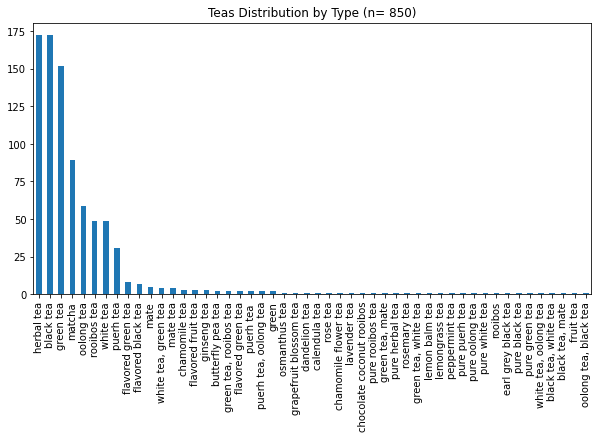

In [17]:
# Data Visualization
# Tea types and times best to drink distribution:
# Types, we can see that herbal and black tea are tied at the top
df['Type'].value_counts().plot(x = 'Type', y ='count', kind = 'bar', figsize = (10,5), title = 'Teas Distribution by Type (n= 850)')

<AxesSubplot:title={'center':'Teas Distribution by Drinking Time (n= 850)'}>

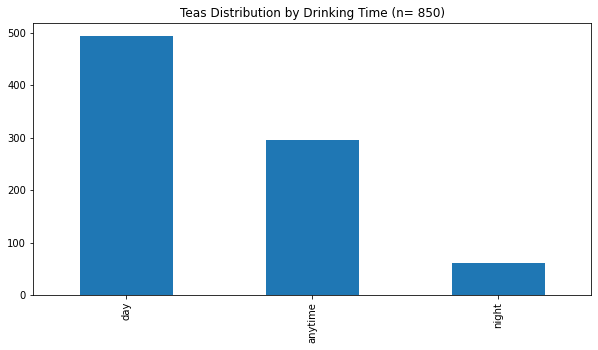

In [18]:
# Time, more teas are best to drink in the AM, which follows that the dataset 
# has a larger propotion of black, green and other caffeinated teas. Herbal 
# teas can be consumed anytime and are recommended in the evening
df['Time'].value_counts().plot(x = 'Time', y ='count', kind = 'bar', figsize = (10,5), title = 'Teas Distribution by Drinking Time (n= 850)')

<AxesSubplot:title={'center':'Word Count Distribution for tea ingredients'}, ylabel='Frequency'>

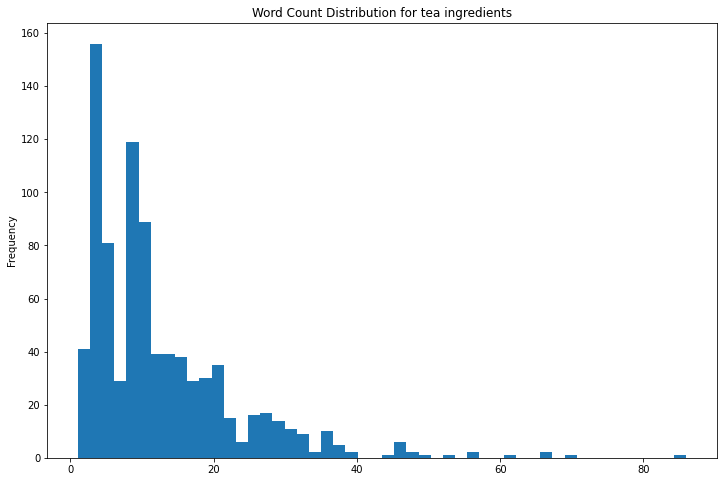

In [30]:
# We can look at the Word Count to gain more insight into the number
# of ingredients used to make commercial tea, 
# First, we'll look at the Ingredients word count.
df['word_count'] = df['Ingredients'].apply(lambda x: len(str(x).split()))
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Tea Ingredients Word Count Distribution')
# The right skew indicates that more teas have more than 1 or 2 ingredients.

<AxesSubplot:title={'center':'Word Count Distribution for tea descriptions'}, ylabel='Frequency'>

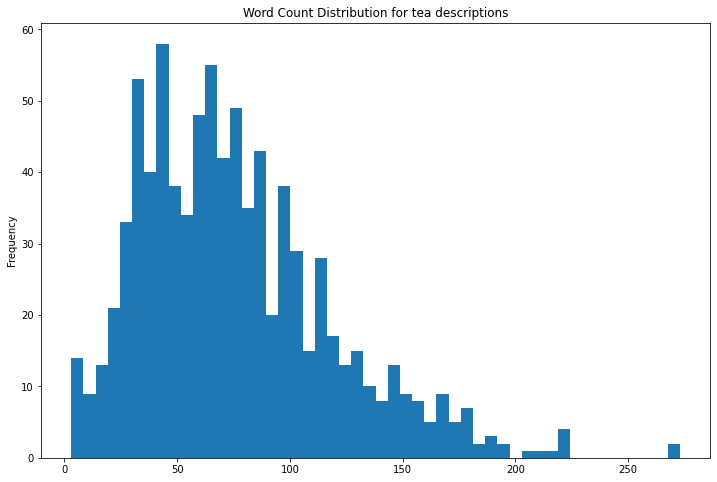

In [19]:
# For the Description we see that most have 50 to 100 words
df['word_count'] = df['Description'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for tea descriptions')

<AxesSubplot:title={'center':'Top 10 Part-of-speech tags in Ingredients'}, ylabel='pos'>

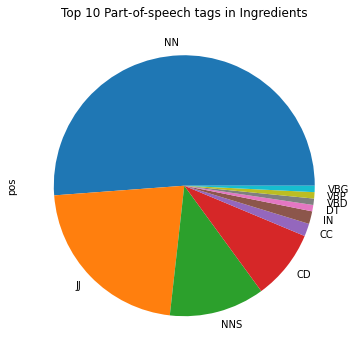

In [42]:
# We can find the lexicon makeup of the longest strings, 
# Description and Ingredients
# Ingredients
from textblob import TextBlob
blob = TextBlob(str(df['Ingredients']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:10]
pos_df.plot(kind = 'pie', figsize=(8, 6), title = "Top 10 Part-of-speech tags in Ingredients")
# for both, most are nouns, HealthPs, which is not surprising

<AxesSubplot:title={'center':'Top 10 Part-of-speech tags in Descriptions'}, ylabel='pos'>

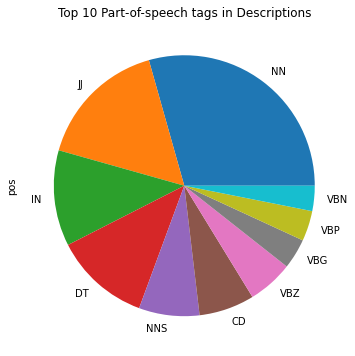

In [46]:
from textblob import TextBlob
blob = TextBlob(str(df['Description']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:10]
pos_df.plot(kind = 'pie', figsize=(8, 6), title = "Top 10 Part-of-speech tags in Descriptions")
# for both, most are nouns, names, which is not surprising

In [65]:
# Preparing text:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Applying all the functions in health problems and storing as a "Ingredients"
df["Ingredients"] = df["Ingredients"].apply(_removeNonAscii)
df["Ingredients"] = df.Ingredients.apply(func = make_lower_case)
df["Ingredients"] = df.Ingredients.apply(func = remove_stop_words)
df["Ingredients"] = df.Ingredients.apply(func=remove_punctuation)

In [67]:
#Print ingredients of the first 5 teas.
df['Ingredients'].head()

0    organic peppermint organic apple organic eucalyptus organic juniper berries organic orange oil n...
1    apple apple citric acid pineapple pineapple sugar hibiscus blossoms white tea natural pomegranat...
2                                                  cane sugar matcha green tea natural mojito flavouring
3    apple apple citric acid pineapple pineapple sugar hibiscus blossoms white tea natural pomegranat...
4                                             coconut nectar matcha green tea natural vanilla flavouring
Name: Ingredients, dtype: object

In [69]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NAs with an empty string
df['Ingredients'] = df['Ingredients'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['Ingredients'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(850, 698)

In [74]:
# From the above shape, we see that there are 698 words in the dataset
# Array mapping from feature integer indices to feature name.
tfidf.get_feature_names_out()[94:104]

array(['brown', 'buckthorn', 'buckwheat', 'bud', 'buds', 'burdock',
       'butter', 'butterfat', 'butterfly', 'butternut'], dtype=object)

In [75]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [76]:
cosine_sim.shape

(850, 850)

In [77]:
cosine_sim[1]

array([0.08248236, 1.        , 0.10591485, 1.        , 0.06166356,
       0.00832702, 0.00938353, 0.28966118, 0.0519636 , 0.10216862,
       0.29194041, 0.04092541, 0.07401869, 0.14779375, 0.11840456,
       0.07034754, 0.12943976, 0.42606256, 0.07697914, 0.14210645,
       0.32130633, 0.00529989, 0.1514569 , 0.04655843, 0.43658254,
       0.15465143, 0.38112656, 0.14135611, 0.29188068, 0.04124007,
       0.11843933, 0.08248236, 0.29194041, 0.012743  , 0.13024933,
       0.08213054, 0.05296262, 0.06482436, 0.07890487, 0.08213054,
       0.00572636, 0.11033669, 0.00881984, 0.07890487, 0.32620415,
       0.10092382, 0.13024933, 0.25421521, 0.08878589, 0.27355967,
       0.10216862, 0.37718569, 0.00763253, 0.08854987, 0.11604635,
       0.01965165, 0.31574322, 0.08892837, 0.057433  , 0.08828914,
       0.13672503, 0.012743  , 0.11840456, 0.21466058, 0.0519636 ,
       0.08954275, 0.11473097, 0.08878589, 0.13024933, 0.12943976,
       0.37588348, 0.04124007, 0.15465143, 0.012743  , 0.42378

In [78]:
# Now that we have the matrix of similarity, we should 
# generate a reverse map of indices and tea names
indices = pd.Series(df.index, index=df['Name']).drop_duplicates()

In [81]:
indices[:5]

Name
Organic Cold 911 Iconic Tin                   0
Pomegrateful Iconic Tin                       1
Mojito Matcha Iconic Tin                      2
Pomegrateful   Limited Edition printed tin    3
Vanilla Matcha Iconic Tin                     4
dtype: int64

In [82]:
# At this point, we can begin building the recommendation function, 
# It will take in Name as input and returns similar teas as output
def get_recommendations(Name, cosine_sim=cosine_sim):
    # Get the index of teas that match the name
    idx = indices[Name]

    # Get the pairwsie similarity scores of all similar teas
    sim_scores = list(enumerate(cosine_sim[idx]))

    #  Based on the similarity scores, sort the tea names
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Find the scores of the 5 most similar teas
    sim_scores = sim_scores[1:6]

    # Get the tea indices
    tea_indices = [i[0] for i in sim_scores]

    # Bring it all together and return the top 5 most similar teas
    return df['Name'].iloc[tea_indices]

In [95]:
df['Name'][363:373]

363                    Herbal Mint
364              English Breakfast
365           Jasmine Dragon Pearl
366                   Sweet Dreams
367                  Flowering Tea
368                  Jasmine White
369           Memories of a Geisha
370                   Arabian Chai
371                   Smoky Oolong
372    Ceremonial Matcha - Premium
Name: Name, dtype: object

In [88]:
get_recommendations('Lavender')

392         Classic Black
276          Blindfold Me
447    Earl Grey Lavender
581    Earl Grey Lavender
318             Chamomile
Name: Name, dtype: object